In [1]:
using Pkg;
Pkg.activate(".")
using Plots, CSV, DataFrames, Polynomials, LinearAlgebra, Statistics

  Activating project at `~/Documents/Spring2024/NumericalAnalysis/NA-FinalProject/src`


### Procedure
1. Parse data

The spline algorithms only work if the x-values of the data are in ascending order. This also means that if, in the same data recording, I walk forward, and then backwards, the algorithm won't work. To account for this we will sort the data

In [2]:
# This will create a dataframe from our file
filename = "../data/03-26-Stadium/Location.csv"
data = CSV.File(open(filename)) |> DataFrame

# using the longitude as our x-values and the altitude as our y-values
# dataframes makes it easy to get these values by using the dot syntax

#USE LATITUDE FOR X-VALUES IN OUR TESTING (THIS DATA IS TAKEN GOING E-W, not N-S)
x = data.longitude;
y = data.altitude;


Let me plot the original data to show you what I mean 

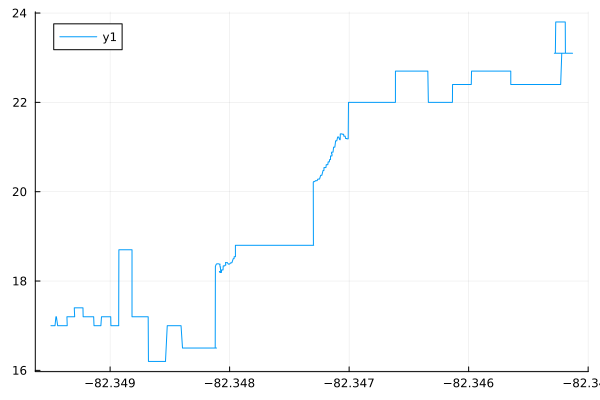

In [3]:
plot(x, y)

Do you see that at the top right?

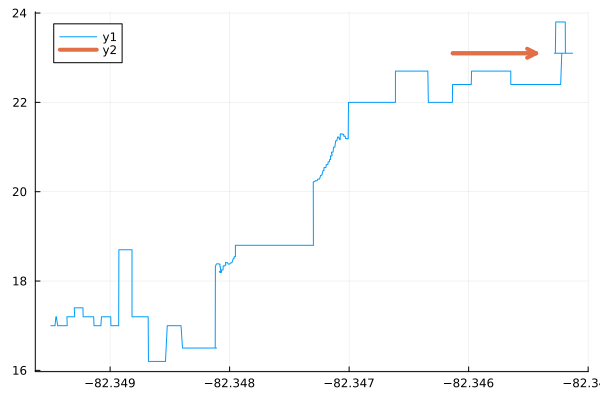

In [4]:
plot!([x[200], x[50]], [y[5], y[5]], arrow=true, l=4)

We don't want loops like that, it's hard for the algorithm to build fitting functions when they occur

In [5]:
#sort the x values to account for any wobble in the data
x_sorted = sort(x, rev=true);

2. Sample some points from the sorted data

In [6]:
"""
     get_spaced_points(x_sorted, y, n=10; rev=true)

Takens in sorted x and y values, returns 'n' number of equally spaced out
points from the data. If inputted x-values are in increasing order, set rev=false
"""
function get_spaced_points(x_sorted, y, n=10; rev=true)
     len = length(x_sorted)
     indices = round.(Int, LinRange(1, len, n))
    
     if rev
          xs = reverse(x_sorted[indices])
          ys = reverse(y[indices])
     else
          xs = x_sorted[indices]
          ys = y_sorted[indices]
     end

     return xs, ys
 end

get_spaced_points

In [7]:
xs, ys = get_spaced_points(x_sorted, y);

3. Setup cubic interpolation method

This is taken directly from the textbook, it appears to be working currently. He uses a different naming convention. To convert --> 
His '$t$' == my '$xs$'  ,   His '$y$' == my '$ys$'

This takes in a sample and returns a function that fits these samples. To plot, we feed into the returned function our data points

In [8]:
"""
    spinterp(t,y)

Construct a cubic not-a-knot spline interpolating function for data
values in `y` given at nodes in `t`.
"""
function spinterp(t,y)
    n = length(t)-1
    h = [ t[k+1]-t[k] for k in 1:n ]

    # Preliminary definitions.
    Z = zeros(n,n);
    In = I(n);  E = In[1:n-1,:];
    J = diagm(0=>ones(n),1=>-ones(n-1))
    H = diagm(0=>h)

    # Left endpoint interpolation:
    AL = [ In Z Z Z ]
    vL = y[1:n]

    # Right endpoint interpolation:
    AR = [ In H H^2 H^3 ];
    vR = y[2:n+1]

    # Continuity of first derivative:
    A1 = E*[ Z J 2*H 3*H^2 ]
    v1 = zeros(n-1)

    # Continuity of second derivative:
    A2 = E*[ Z Z J 3*H ]
    v2 = zeros(n-1)

    # Not-a-knot conditions:
    nakL = [ zeros(1,3*n) [1 -1 zeros(1,n-2)] ]
    nakR = [ zeros(1,3*n) [zeros(1,n-2) 1 -1] ]

    # Assemble and solve the full system.
    A = [ AL; AR; A1; A2; nakL; nakR ]
    v = [ vL; vR; v1; v2; 0; 0 ]
    z = A\v

    # Break the coefficients into separate vectors.
    rows = 1:n
    a = z[rows]
    b = z[n.+rows];  c = z[2*n.+rows];  d = z[3*n.+rows]
    S = [ Polynomial([a[k],b[k],c[k],d[k]]) for k in 1:n ]

    # This function evaluates the spline when called with a value
    # for x.
    return function (x)
        if x < t[1] || x > t[n+1]    # outside the interval
            return NaN
        elseif x==t[1]
            return y[1]
        else
            k = findlast(x .> t)    # last node to the left of x
            return S[k](x-t[k])
        end
    end
end

spinterp

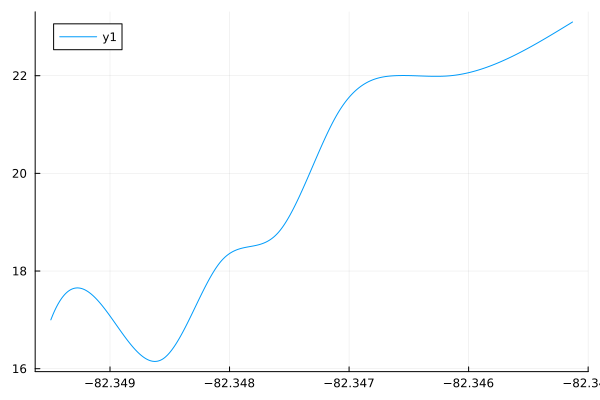

In [9]:
cspline_f = spinterp(xs, ys)
plot(x_sorted, cspline_f.(x_sorted))

Plotting it over top of our original data

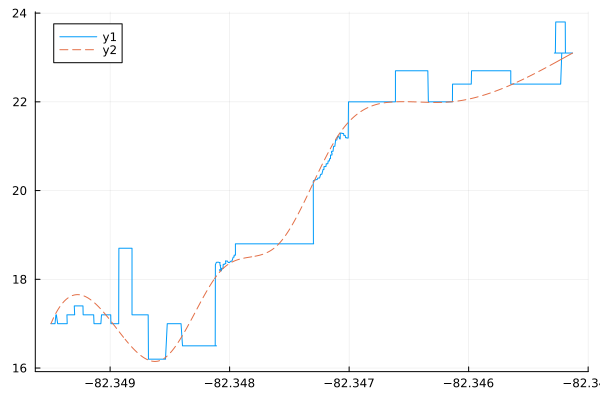

In [10]:
plt = plot(x, y)
plot!(plt, x, cspline_f.(x), ls=:dash)

Since I built the model using the sorted x-values, it's probably more accurate to show it overlaid on that plot instead

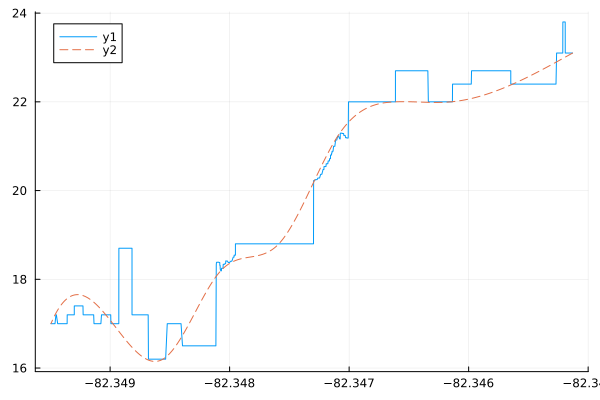

In [11]:
plt = plot(x_sorted, y)
plot!(plt, x_sorted, cspline_f.(x_sorted), ls=:dash)

4. Piece together into an easily usable function
   
I've opted for a function that plots an overlay of the spline onto a preexisting plot. I think this makes it easy to plot a bunch of splines at different values of n. It moreover allows for you to easily change the styling of the original plot without having to edit the function every time or pass in a bunch of parameters.

In [12]:
"""
     plot_cubic_spline(plt, x, y, n=10; la=0.6, fa=0.0)

Takes in a plot of the original data and overlays a cubic spline using `n` data points. If you want to shade the area between
the plots, set fa=[SOME VALUE 0.0-1.0]. You can also adjust how dark a line is by setting la=[SOME VALUE 0.0-1.0]
"""
function plot_cubic_spline(plt, x, y, n=10; la=0.6, fa=0.0)
     x_sorted = sort(x, rev=true);
     xs, ys = get_spaced_points(x_sorted, y, n);
     cspline_f = spinterp(xs, ys)
     plot!(plt, x_sorted, cspline_f.(x_sorted), fillrange=y, fillalpha = fa, label="n=$n",ls=:dash, alpha=la)
end

plot_cubic_spline

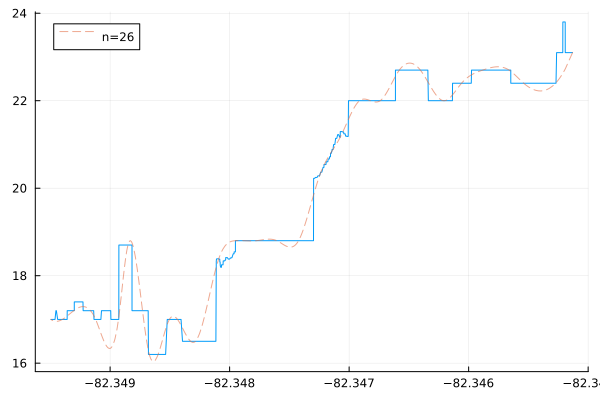

In [13]:
plt = plot(x_sorted, y, label=:none)
plot_cubic_spline(plt, x, y, 26)

Demo showing how to overlay multiple

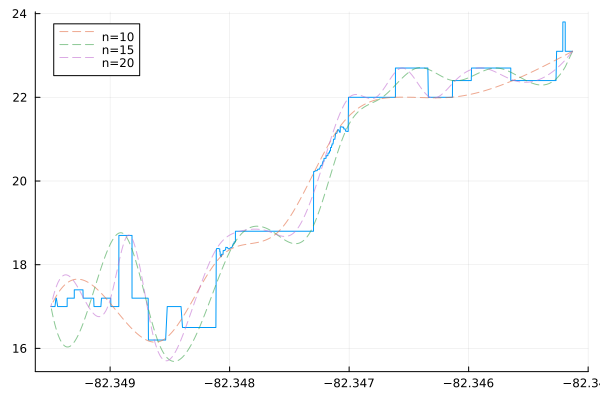

In [14]:
ns = [10, 15, 20]

plt = plot(x_sorted, y, label=:none)

for n in ns
     plot_cubic_spline(plt, x, y, n)
end

plt

Demo showing how to adjust shading and line alpha

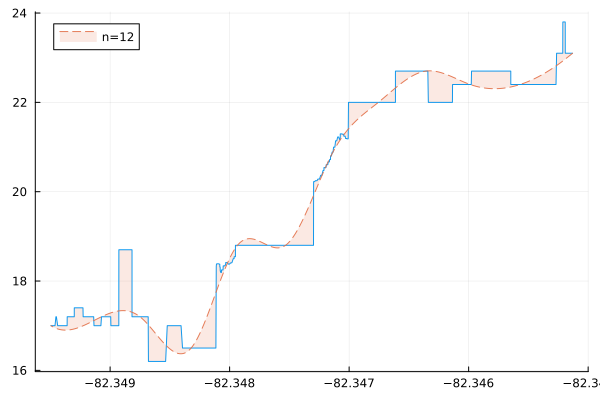

In [15]:
plt = plot(x_sorted, y, label=:none)
plot_cubic_spline(plt, x, y, 12; fa=0.15, la=0.9)

In [25]:
plot(x->x, 0, 10, st=:surface)

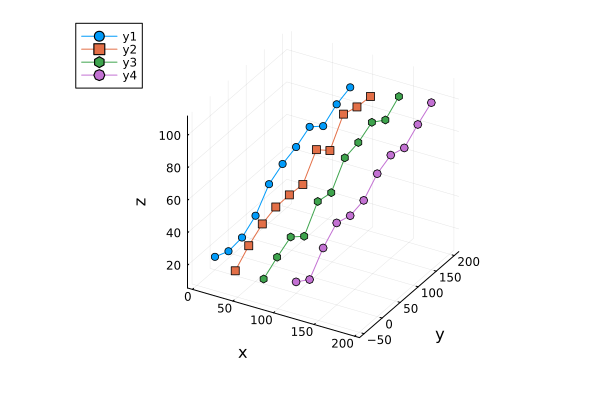

In [112]:
function squiggles(shift_x)
     x = 0:10:100     
     x_shifted = x .+ shift_x
     y = x .* 1.5
     z = x .+ rand(1:15, length(x))

     return x_shifted, y, z
end

x1, y1, z1 = squiggles(0)
x2, y2, z2 = squiggles(25)
x3, y3, z3 = squiggles(60)
x4, y4, z4 = squiggles(100)

plt = plot(x1, y1, z1, marker=:circle, alpha=1, aspect_ratio=.5, xlabel="x", ylabel="y", zlabel="z")
plot!(x2, y2, z2, marker=:square, alpha=1)
plot!(x3, y3, z3, marker=:hexagon)
plot!(x4, y4, z4, marker=:octagon)

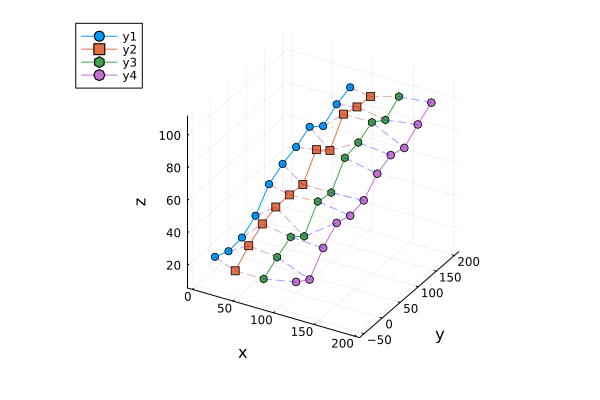

In [114]:
for i = 1:length(x1)
     plot!(plt, [x1[i], x2[i]], [y1[i], y2[i]], [z1[i], z2[i]], alpha=0.2, color=:purple, label=:none, ls=:dash)
     plot!(plt, [x2[i], x3[i]], [y2[i], y3[i]], [z2[i], z3[i]], alpha=0.2, color=:brown, label=:none, ls=:dash)
     plot!(plt, [x3[i], x4[i]], [y3[i], y4[i]], [z3[i], z4[i]], alpha=0.2, color=:blue, label=:none, ls=:dash)
end


plt

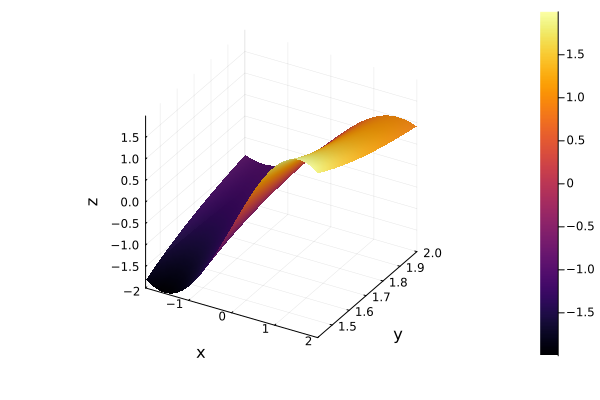

In [127]:
x=range(-2,stop=2,length=100)
y=range(sqrt(2),stop=2,length=100)
f(x,y) = 4/y^2 * sin(x) 

surface(x, y, f, xlabel="x", ylabel="y", zlabel="z")